In [83]:
import numpy
import scipy.stats
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Times New Roman"]})
plt.rcParams["font.family"] = "Times New Roman"

## Generic functions

In [84]:
def add_labels(graph_title, x_label, y_label):
    """Add labels to graphs"""
    plt.title(graph_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

## Papers

[Identifying elastoplastic parameters with Bayes’ theorem considering output error, input error and model uncertainty](https://www.sciencedirect.com/science/article/pii/S0266892018300547)

[A Tutorial on Bayesian Inference to Identify Material Parameters in Solid Mechanics](https://link.springer.com/article/10.1007/s11831-018-09311-x)

## Parameters

A linear elastic-perfectly plastic specimen is considered with Young's modulus $E =$ 210 GPa and yield stress $\sigma_{y0} =$ 0.25 GPa. 

The parameters to be identified for the linear elastic-perfectly plastic model are the Young's modulus and the initial yield stress, which are stored in the parameter vector $\textbf{x}$:

 $$\textbf{x}=[E \; \sigma_{y0}]^T$$

In [86]:
E_accurate = 210  # Young's modulus (GPa)
yield_stress = 0.25  # Yield stress (GPa)
s_noise = 0.01  # Noise in the stress measurement (GPa)


mean_vector_prior = numpy.array([[200], [0.29]])  # Mean vector (GPa)
cov_matrix_prior = numpy.array([[2500, 0], [0, 2.7778E-4]])  # Covariance matrix (GPa^2)

parameter_vector = mean_vector_prior


## Experimental data

Twelve experimental measurements are provided. The noise in the stress measurements is a normal distribution with a zero mean and a standard deviation of $s_{noise}$.

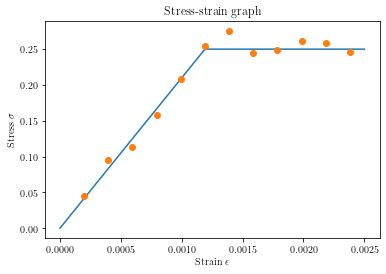

In [96]:
strain_measured = [0.198E-3, 0.397E-3, 0.595E-3, 0.793E-3, 0.992E-3, 1.190E-3, 
                   1.388E-3, 1.587E-3, 1.785E-3, 1.985E-3, 2.182E-3, 2.383E-3]
stress_measured = [0.0448, 0.0955, 0.113, 0.158, 0.209, 0.255, 
                   0.276, 0.244, 0.249, 0.262, 0.259, 0.246]

plt.plot(strain, stress)
plt.plot(strain_measured, stress_measured, 'o')
add_labels("Stress-strain graph", "Strain $\epsilon$", "Stress $\sigma$")

## Constitutive model

The stress-strain response of the linear elastic-perfectly plastic model during monotonic tension can be written as:

$$\sigma(\epsilon, \textbf{x}) = 
    \begin{cases}
        E\epsilon \quad \text{if} \quad \epsilon \leqslant \frac{\sigma_{y0}}{E} \\
        \sigma_{y0} \quad \text{if} \quad \epsilon > \frac{\sigma_{y0}}{E}
    \end{cases}$$

Using the Heaviside step function $h$, the stress-strain response of the linear elastic-perfectly plastic model can alternatively be expressed as:

$$\sigma(\epsilon, \textbf{x}) = E\epsilon\left(1 - h\left(\epsilon - \frac{\sigma_{y0}}{E}\right)\right) + \sigma_{y0}h\left(\epsilon - \frac{\sigma_{y0}}{E}\right)$$

Where $\textbf{x}$ is the parameter vector:

$$\textbf{x} = [E \; \sigma_{y0}]^T$$

$E$ is the Young's modulus and $\sigma_{y0}$ is the initial yield stress.

In [85]:
def calculate_stress(strain, yield_stress, E):
    yield_strain = yield_stress / E
    if strain < yield_strain:
        stress = E * strain
    elif strain > yield_strain:
        stress = yield_stress
    return stress

## Mean stress-strain graph

In [87]:
def build_mean_stress(E_accurate, yield_stress, strain):
    
    stress = numpy.zeros(numpy.shape(strain))
        
    for i in range(len(strain)):
        stress[i] = E_accurate * strain[i]
        if stress[i] > yield_stress:
            stress[i] = yield_stress
            
    return stress

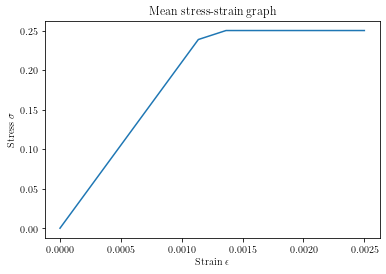

In [103]:
strain = numpy.linspace(0, 2.5E-3, 12)
stress = build_mean_stress(E_accurate, yield_stress, strain)

plt.plot(strain, stress)
add_labels("Mean stress-strain graph", "Strain $\epsilon$", "Stress $\sigma$")

## Likelihood

$$\pi(y|\textbf{x}) = \frac{1}{s_{noise}\sqrt{2\pi}}exp\left(-{\frac{\left(y - E\epsilon\left(1 - h\left(\epsilon - \frac{\sigma_{y0}}{E}\right)\right) - \sigma_{y0}h\left(\epsilon - \frac{\sigma_{y0}}{E}\right)\right)^2}{2s^2_{noise}}}\right)$$

## Prior

$$\pi(\textbf{x}) = exp\left(-\frac{(\textbf{x}-\overline{\textbf{x}})^T\Gamma^{-1}(\textbf{x}-\overline{\textbf{x}})}{2} \right)$$

The following mean vector and convariance matrix are selected:

$$\overline{\textbf{x}} = \begin{bmatrix} 200 \\ 0.29 \end{bmatrix} \; \text{GPa}, \quad \Gamma_\textbf{x} = \begin{bmatrix} 2500 & 0 \\ 0 & 2.7778 \times 10^{-4} \end{bmatrix} \; \text{GPa}^2$$

In [89]:
def calculate_prior(parameter_vector, mean_vector, cov_matrix):
    temp_var = parameter_vector - mean_vector
    numerator = numpy.transpose(temp_var) * numpy.linalg.inv(cov_matrix) * (temp_var)
    pdf = numpy.exp(-numerator / 2)
    return pdf

## Posterior

$$\pi(\textbf{x}|\textbf{y}) = exp\left(-\left(\frac{(\textbf{x}-\overline{\textbf{x}})^T\Gamma^{-1}(\textbf{x}-\overline{\textbf{x}})}{2} + {\frac{\Sigma_{i=1}^{n_m}\left(y_i - E\epsilon_i\left(1 - h\left(\epsilon_i - \frac{\sigma_{y0}}{E}\right)\right) - \sigma_{y0}h\left(\epsilon_i - \frac{\sigma_{y0}}{E}\right)\right)^2}{2s^2_{noise}}}\right)\right)$$

Where $n_m$ is the number of measurements, and $s_{noise}$ is the noise in the stress measurement (standard deviation). 


In [90]:
def calculate_posterior(parameter_vector, mean_vector, cov_matrix, 
                        strain, yield_stress, E, measurements, s_noise):
        
    pdf = calculate_prior(parameter_vector, mean_vector, cov_matrix)
    
    total = 0
    for i in range(len(measurements)):
        total += (measurements[i] - calculate_stress(strain[i], yield_stress, E))**2
    
    print(total)
    posterior = numpy.exp(-(pdf + (total / (2 * s_noise**2))))
    
    return posterior

## Markov Chain Monte Carlo

Determine the PDF for the Young's modulus $E$ and yield stress $\sigma_{y0}$

In [104]:
n_samples = 10000
n_burnt_samples = 3000

test = calculate_posterior(parameter_vector, mean_vector_prior, cov_matrix_prior, strain, 
                           0.29, 200, stress_measured, s_noise)
print(test)

0.014464091652892554
[[1.43657917e-32 1.43657917e-32]
 [1.43657917e-32 1.43657917e-32]]
